## Block 1: Import libraries

-Import pandas for data manipulation and handling.  
-Import networkx for creating and analyzing network graphs.  
-Import plotly.graph_objs and plotly.offline for creating interactive and static visualizations.  
  

In [1]:
import pandas as pd
import networkx as nx
import plotly.graph_objs as go
import plotly.offline as pyo


## Block 2: Define a function to create the network graph

-Define a function **create_network_graph** that takes input_value and df (dataframe) as arguments.  
-Create an empty Graph object (G) from networkx.  
-Filter the dataframe based on the input_value, searching in both 'Name' and 'Entity_Name' columns.  
-For each row, extract the 'Name' (source node), 'Entity_Name' (target node)  
-Iterate through the filtered dataframe and add nodes and edges for primary connections, secondary connections, tertiary connections, and quaternary connections by adding nodes with appropriate attributes and connecting them with edges.  

In [2]:
# Function to create the network graph
def create_network_graph(input_value, df):
    # Create an empty Graph object
    G = nx.Graph()

    # Filter the dataframe based on input value
    primary_df = df[df['Name'].str.contains(input_value, case=False) | df['Entity_Name'].str.contains(input_value, case=False)]

    # Iterate through primary_df and add nodes and edges
    for _, row in primary_df.iterrows():
        name = row['Name']
        entity_name = row['Entity_Name']
        individual_address = row['Individual_Address']
        position = row['Position']

        # Add nodes and edges for primary connections
        G.add_node(name, label=name, position=position, entity_name=entity_name)
        G.add_node(entity_name, label=entity_name)
        G.add_edge(name, entity_name)

        # Add nodes and edges for secondary connections
        secondary_df = df[df['Entity_Name'] == entity_name]
        for _, sub_row in secondary_df.iterrows():
            sub_name = sub_row['Name']
            G.add_node(sub_name, label=sub_name, position=sub_row['Position'], entity_name=entity_name)
            G.add_edge(sub_name, entity_name)

            # Add nodes and edges for tertiary connections
            tertiary_df = df[df['Name'] == sub_name]
            for _, tert_row in tertiary_df.iterrows():
                tert_entity_name = tert_row['Entity_Name']
                G.add_node(tert_entity_name, label=tert_entity_name)
                G.add_edge(sub_name, tert_entity_name)

                # Add nodes and edges for quaternary connections
                quaternary_df = df[df['Entity_Name'] == tert_entity_name]
                for _, quat_row in quaternary_df.iterrows():
                    quat_name = quat_row['Name']
                    G.add_node(quat_name, label=quat_name, position=quat_row['Position'], entity_name=tert_entity_name)
                    G.add_edge(quat_name, tert_entity_name)

    return G

## Block 3: Define a function to plot the network graph
-This block of code is responsible for visualizing the network graph created in Block 2. It uses the Plotly library to create an interactive plot of the network graph, which can be saved as an HTML file.  
-Define a function **plot_network_graph** that takes G (Graph object), input_value, and df (dataframe) as arguments.  
-Create two empty lists: edge_trace for edges and node_trace for nodes.  
-Loop through the graph edges, create lines with Plotly, and add them to edge_trace.  
-Loop through the graph nodes, create points with Plotly, and add them to node_trace.  
-Customize node and edge appearance (size, color, hover text) using Plotly.  
-Combine edge_trace and node_trace, set up plot layout, and create the final plot with Plotly.  
-Save the plot as an interactive HTML file using plotly.offline.   

In [3]:
# Function to plot the network graph
def plot_network_graph(G, input_value, df):
    # Generate the layout for the graph
    pos = nx.spring_layout(G, seed=42)

    # Initialize lists to store edge coordinates
    edge_x = []
    edge_y = []
    # Calculate coordinates for edges
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    # Create a scatter plot for edges
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    # Initialize lists to store node coordinates and attributes
    node_x = []
    node_y = []
    node_text = []
    node_hovertext = []
    node_color = []
    node_size = []
    # Calculate coordinates and attributes for nodes
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
       
        if 'position' in G.nodes[node]:
            node_info = f"{G.nodes[node]['label']}"
            companies_positions = df[df['Name'] == G.nodes[node]['label']][['Entity_Name', 'Position']].drop_duplicates()
            hover_info = "Companies & Positions: <br>" + "<br>".join([f"{row['Entity_Name']}: {row['Position']}" for _, row in companies_positions.iterrows()])
            node_color.append('blue')
            node_size.append(10)
        else:
            node_info = f"{G.nodes[node]['label']}"
            hover_info = f"Entity Name: {G.nodes[node]['label']}"
            node_color.append('green')
            node_size.append(30)
        node_text.append(node_info)
        node_hovertext.append(hover_info)

    # Create a scatter plot for nodes
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        text=node_text,
        mode='markers+text',
        hovertext=node_hovertext,
        hoverinfo='text',
        marker=dict(
            color=node_color,
            size=node_size,
            line=dict(width=2)
        ),
        textfont=dict(color='white')
    )

    # Create a Figure object with edge_trace and node_trace
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Network Graph',
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        plot_bgcolor='black'
                    )
    )

    # Save and open the plot as an HTML file
    plot_file = 'network_graph.html'
    
    pyo.plot(fig, filename=plot_file, auto_open=True)



## Block 4: Import Anvil server and connect

-Import anvil.server for creating a connection between the Python script and Anvil app.  
-Connect to the Anvil server using a connection string.  

In [4]:
import anvil.server
anvil.server.connect("server_D2GC5XM7IN5U5KQZS77CHMHL-7M3PKZA4T6WCU7AT")


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


## Block 5: Define function to get the path of the generated network graph HTML file

-Import os module for interacting with the file system.  
-Define a function path that returns the path to the saved network_graph.html file in the Downloads folder.  
-Generates the path where the graph is saved on the users computer


In [5]:
import os

def path():
    downloads_folder = os.path.join(os.path.expanduser("~"), "Downloads")
    link=downloads_folder+"\\network_graph.html"
    return link


## Block 6: Create Anvil server callable function to generate network graph.

-Define a callable function createNetwork that takes a name as input.  
-Read the CSV data using pandas.  
-Create a network graph by calling the create_network_graph function with the input value and dataframe.  
-Plot the network graph by calling the plot_network_graph function with the graph object, input value, and dataframe.  
-Print and return the path to the saved plot by calling the path function.  



In [6]:

@anvil.server.callable
def createNetwork(name):
    
    input_value = name
    df=pd.read_csv('https://github.com/DALIAALISIDDIG/data/blob/aaf9161d4f9bc8e166c4d9755f36554d692c2178/MERGED%20SHEET.csv/?raw=true')
    G = create_network_graph(input_value, df)
    plot_network_graph(G, input_value, df)
    print(path())
    return(path())


C:\Users\ROEYE\Downloads\network_graph.html
C:\Users\ROEYE\Downloads\network_graph.html
Anvil websocket closed (code 1006, reason=Going away)
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink


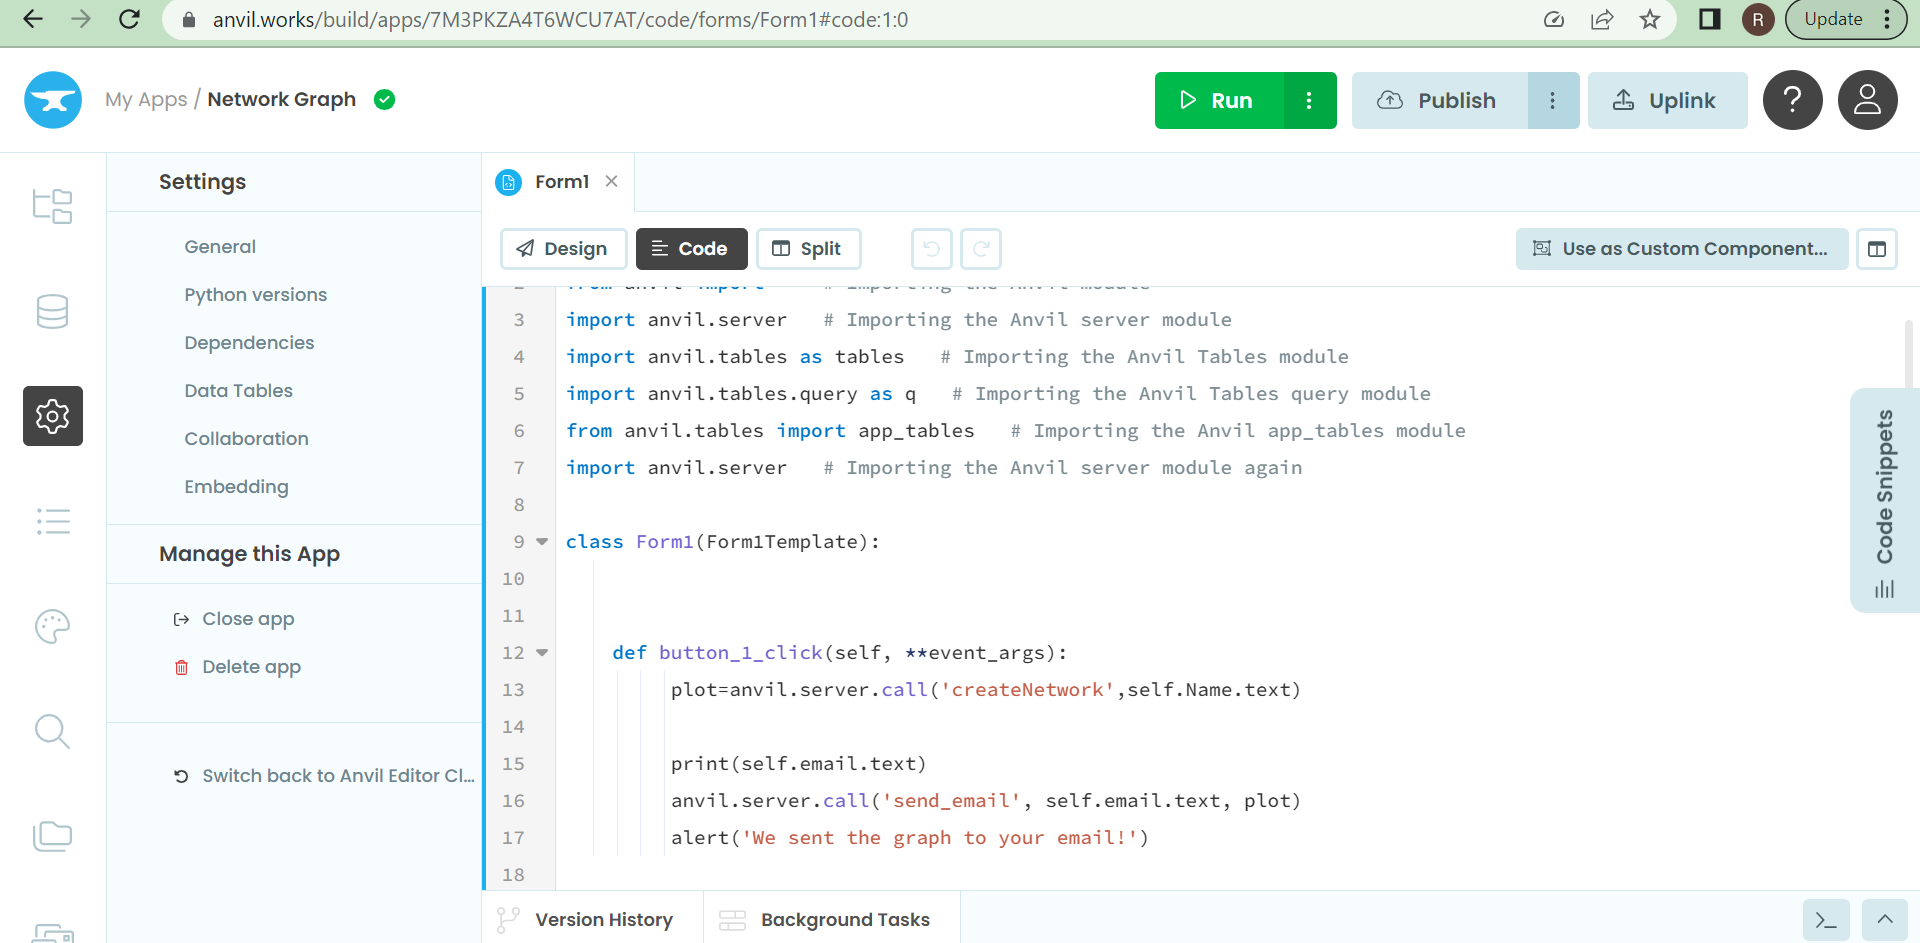




[Anvil Web App](https://7m3pkza4t6wcu7at.anvil.app/IFQDKPIEQZUCEJB222K73M3T)

## Block 7: Create a network graph without the Anvil web app
-Define the main function.  
-Prompt the user for input and read the CSV file from a URL using pandas.  
-Create a network graph by calling the create_network_graph function with the user input and dataframe.  
-Plot the network graph by calling the plot_network_graph function with the graph, user input, and dataframe.  

In [ ]:
def main():
    input_value = input("Enter a Name or Entity_Name: ")
    df = pd.read_csv('https://github.com/DALIAALISIDDIG/data/blob/aaf9161d4f9bc8e166c4d9755f36554d692c2178/MERGED%20SHEET.csv/?raw=true')
    G = create_network_graph(input_value, df)
    plot_network_graph(G, input_value, df)

if __name__ == "__main__":
    main()
